# MeDAL Dataset (200 context) - Preprocessing and Model Training with GloVe + LSTM + Self-Attention


This notebook presents a full pipeline for training a neural network model on the MeDAL dataset, focusing on medical abbreviation disambiguation. The key steps include:
- Ensuring reproducibility and loading project configurations.
- Loading and preprocessing the MeDAL dataset splits (train, valid) using a whitespace tokenizer (can be adjusted as per your choice).
- Extracting context windows of 200 words—specifically, 100 words to the left and 100 to the right of each abbreviation instance.
- Saving tokenized context windows as `.parquet` files for efficient access.
- Building a custom vocabulary from training data (with a minimum frequency threshold) and initializing GloVe embeddings.
- Implementing a `LazyEmbeddingDataset` for efficient data loading and embedding lookup.
- Training a hybrid LSTM + Multi-Head Self-Attention model with residual connections, attention-based summarization, and contextual features.
- Leveraging a reusable ModelTrainer class for training and evaluation, including training visualizations.


This setup provides a solid foundation for experimenting with different embedding strategies and model architectures for medical abbreviation expansion tasks.

In [1]:
%load_ext autoreload
%autoreload 2
%run ../setup.py

from src.data.medal import MeDALSubset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import yaml
from src.models.trainer import ModelTrainer
from src.vectorizer.trainable import TrainableEmbedding
from src.vectorizer.glove_embeddings import GloVeEmbedding
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from env import ProjectPaths
from src.utils import save_embeddings_to_file
import pyarrow.parquet as pq
import numpy as np
from tqdm import tqdm
from env import ProjectPaths
import yaml
from src.models.factory import ModelFactory
from torch.optim import Adam, AdamW
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
import json
import random

# random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Environment set up: sys.path updated, working dir set to project root.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prashanthjaganathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prashanthjaganathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### Download and load the dataset

In [2]:
medal_dataset = MeDALSubset('MeDAL')
data, train_data, val_data, test_data = medal_dataset.load_dataset()
class_to_idx = medal_dataset.class_to_idx
del data, val_data, test_data

MeDAL dataset initialized with name: MeDAL
Dataset downloaded to: /home/jaganathan.p/.cache/kagglehub/datasets/xhlulu/medal-emnlp/versions/4
Dataset moved to: /home/jaganathan.p/pretaining-language-models-for-medical-text/dataset
Total number of classes: 22555


#### Load configurations

In [23]:
%load_ext autoreload
%autoreload 2

def load_config(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('config/config.yaml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Tokenize train and valid sets using whitespace tokenizer and store in `.parquet` file

In [16]:
tokens_and_locations = medal_dataset.tokenize('whitespace', splits=['train'])
contexts = medal_dataset.extract_context_from_tokens(
    tokens_and_locations,
    context_window=config['datasets']['medal']['context_window'])
contexts_df = pd.DataFrame({
    'ABSTRACT_ID': medal_dataset.train_data['ABSTRACT_ID'],
    'CONTEXT': contexts})
contexts_df.head()

# Save as a Parquet file
dir = ProjectPaths.DATASET_DIR.value / 'medal' / 'whitespace_tokenized_subset_200_ctx'
dir.mkdir(parents=True, exist_ok=True)
file_name = dir / "train.parquet"
contexts_df.to_parquet(file_name)
print('Parquet file saved successfully!')


Documents: 100%|██████████| 3000000/3000000 [00:59<00:00, 50517.62it/s] 


Parquet file saved successfully!


In [17]:
tokens_and_locations = medal_dataset.tokenize('whitespace', splits=['valid'])
contexts = medal_dataset.extract_context_from_tokens(
    tokens_and_locations,
    context_window=config['datasets']['medal']['context_window'])
contexts_df = pd.DataFrame({
    'ABSTRACT_ID': medal_dataset.val_data['ABSTRACT_ID'],
    'CONTEXT': contexts})
contexts_df.head()

# Save as a Parquet file
dir = ProjectPaths.DATASET_DIR.value / 'medal' / 'whitespace_tokenized_subset_200_ctx'
dir.mkdir(parents=True, exist_ok=True)
file_name = dir / "valid.parquet"
contexts_df.to_parquet(file_name)
print('Parquet file saved successfully!')


Documents: 100%|██████████| 999999/999999 [00:21<00:00, 47243.47it/s] 


Parquet file saved successfully!


In [5]:
train_tokens = pd.read_parquet("dataset/medal/whitespace_tokenized_subset_200_ctx/train.parquet", engine="pyarrow").squeeze()

# to make it as a list[list[str]]
tokenized_train_corpus = [context.tolist() for context in tqdm(train_tokens['CONTEXT'], 'Docs', len(train_tokens['CONTEXT']))] 
print(f'Number of documents in train corpus: {len(tokenized_train_corpus)}')

Docs: 100%|██████████| 3000000/3000000 [00:33<00:00, 88974.83it/s] 


Number of documents in train corpus: 3000000


#### Create vocabulary from the train set

In [24]:
from collections import Counter

min_word_freq = 2
counter = Counter()
# tokenized_train_corpus is a list of tuples: (list_of_tokens, abbreviation)
for tokens in tokenized_train_corpus:
    counter.update(tokens)

external_vocab = {"<PAD>": 0, "<UNK>": 1}
for token, freq in counter.items():
    if freq >= min_word_freq:
        external_vocab[token] = len(external_vocab)

print(f"External vocab size: {len(external_vocab)}")

External vocab size: 1002737


In [25]:
config_glove = config['embedding_models']['glove']
config_glove['external_vocab'] = external_vocab  # Pass the external vocabulary

### Model Training

First, let's create the dataloader with embeddings as features and labels.

In [26]:
class LazyEmbeddingDataset(Dataset):
    def __init__(
            self, 
            file_path, 
            embedding_model, 
            labels, 
            class_to_idx, 
            return_tokens=True,
            max_seq_len=None):
        """
        Args:
            file_path (str): Path to the Parquet file containing the tokenized text.
            embedding_model: The custom embedding model (e.g., GloVeEmbedding).
            labels (list): Labels corresponding to each document.
            class_to_idx (dict): Mapping from class label to integer index.
            max_seq_len (int, optional): Max sequence length for padding/truncating.
        """
        self.file_path = file_path
        table = pq.read_table(self.file_path)
        self.tokenized_corpus = table['CONTEXT']  # Assuming the corpus is tokenized in the file
        self.embedding_model = embedding_model
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.max_seq_len = max_seq_len
        self.label_names = set(self.labels)
        self.return_tokens = return_tokens

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the tokens for the current document
        tokens = self.tokenized_corpus[idx].as_py()  # Convert PyArrow StringScalar to string

        if self.return_tokens:
            embeddings = self.embedding_model.token_indices(tokens)
        else:
            # Compute the embeddings for this document on the fly using the embedding model
            embeddings = self.embedding_model.embed(tokens)  # shape: (seq_len, embedding_dim)

        # Convert to numpy arrays
        # embeddings = np.array(embeddings, dtype=np.float32)
        seq_len = len(embeddings)
        embedding_dim = self.embedding_model.embedding_dim
        embeddings = embeddings + [0] * (self.max_seq_len - seq_len) if seq_len < self.max_seq_len else embeddings[:self.max_seq_len]

        # Padding/Truncation based on max_seq_len
        # if self.max_seq_len is not None:
        #     if seq_len < self.max_seq_len:
        #         if self.return_tokens:
        #             pad = np.zeros((self.max_seq_len - seq_len), dtype=np.float32)
        #             embeddings = np.concatenate((embeddings, pad), axis=0)
        #         else:
        #             pad = np.zeros((self.max_seq_len - seq_len, embedding_dim), dtype=np.float32)
        #             embeddings = np.vstack([embeddings, pad])
        #     else:
        #         embeddings = embeddings[:self.max_seq_len]

        # Mask to indicate valid tokens
        mask = np.ones(seq_len, dtype=np.float32)
        if self.max_seq_len is not None and seq_len < self.max_seq_len:
            mask = np.concatenate([mask, np.zeros(self.max_seq_len - seq_len, dtype=np.float32)])

        # Convert label to index
        label = self.labels[idx]
        label_idx = self.class_to_idx[label]

        return (torch.tensor(embeddings, dtype=torch.long),
                torch.tensor(mask, dtype=torch.long),  # Return the mask
                torch.tensor(label_idx, dtype=torch.long))


def create_lazy_dataloader(file_path, embedding_model, labels, class_to_idx, batch_size, max_seq_len=None, shuffle=False):
    dataset = LazyEmbeddingDataset(file_path, embedding_model, labels, class_to_idx, max_seq_len=max_seq_len, return_tokens=True)
    
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        num_workers=16, 
        pin_memory=True
        )
    # return dataset

In [27]:
glove_embedding_model = GloVeEmbedding(**config['embedding_models']['glove'])

max_seq_len = config['datasets']['medal']['max_sequence_length']
batch_size = config['training']['hyperparameters']['batch_size']

trainloader = create_lazy_dataloader(
    'dataset/medal/whitespace_tokenized_subset_200_ctx/train.parquet', 
    glove_embedding_model, 
    medal_dataset.train_data['LABEL'],
    class_to_idx, 
    batch_size=batch_size,
    max_seq_len=max_seq_len,
    shuffle=True
)


valloader = create_lazy_dataloader(
    'dataset/medal/whitespace_tokenized_subset_200_ctx/valid.parquet', 
    glove_embedding_model, 
    medal_dataset.val_data['LABEL'],
    class_to_idx, 
    batch_size=batch_size,
    max_seq_len=max_seq_len,
    shuffle = False
    )

#### Execute training pipeline

In [10]:
# Use the new dataloaders
model_trainer = ModelTrainer(config_file='config.yaml')
train_results = model_trainer.train(
    trainloader,
    valloader,
    dataset='medal',
    embedding_dim=100,
    embedding_model = glove_embedding_model
)

------- lstm_and_self_attention --------
{'lstm_units': 2, 'lstm_hidden_dim': 128, 'num_attention_heads': 16, 'dropout': 0.3, 'max_sequence_length': 200, 'num_classes': 22555, 'embedding_dim': 100, 'create_embedding_layer': True, 'embedding_model': <src.vectorizer.glove_embeddings.GloVeEmbedding object at 0x2ba0961b92d0>}


/home/jaganathan.p/pretaining-language-models-for-medical-text/src/models/model_architectures/lstm_self_attention.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight.data.copy_(torch.tensor(embedding_model.embedding_matrix))
Training:  21%|██▏       | 10008/46875 [02:31<09:17, 66.16it/s]

[Epoch 1] Batch 10000/46875 - Avg Loss (last 10000): 7.7958


Training:  43%|████▎     | 20011/46875 [05:02<06:53, 64.99it/s]

[Epoch 1] Batch 20000/46875 - Avg Loss (last 10000): 4.7447


Training:  64%|██████▍   | 30007/46875 [07:33<04:15, 65.99it/s]

[Epoch 1] Batch 30000/46875 - Avg Loss (last 10000): 3.5812


Training:  85%|████████▌ | 40013/46875 [10:12<01:42, 66.67it/s]

[Epoch 1] Batch 40000/46875 - Avg Loss (last 10000): 3.3684


validating:   0%|          | 0/15625 [00:00<?, ?it/s]/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
validating: 100%|██████████| 15625/15625 [01:39<00:00, 157.77it/s]


Validation Loss: 2.9442, Accuracy: 0.6549, Precision: 0.6663, Recall: 0.6549
Epoch 1/10 - Train Loss: 0.0725, Train Acc: 0.4398, Prec: 0.4478, Recall: 0.4398, Val Acc: 0.6549, Val Prec: 0.6663, Val Recall: 0.6549


/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  21%|██▏       | 10009/46875 [02:31<09:15, 66.40it/s]

[Epoch 2] Batch 10000/46875 - Avg Loss (last 10000): 3.1314


Training:  43%|████▎     | 20012/46875 [05:03<06:44, 66.41it/s]

[Epoch 2] Batch 20000/46875 - Avg Loss (last 10000): 3.1211


Training:  64%|██████▍   | 30008/46875 [07:35<04:19, 64.97it/s]

[Epoch 2] Batch 30000/46875 - Avg Loss (last 10000): 3.0824


Training:  85%|████████▌ | 40011/46875 [10:07<01:43, 66.04it/s]

[Epoch 2] Batch 40000/46875 - Avg Loss (last 10000): 3.0558


validating:   0%|          | 0/15625 [00:00<?, ?it/s]/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
validating: 100%|██████████| 15625/15625 [01:39<00:00, 156.82it/s]


Validation Loss: 2.7728, Accuracy: 0.6967, Precision: 0.7023, Recall: 0.6967
Epoch 2/10 - Train Loss: 0.0482, Train Acc: 0.6419, Prec: 0.6341, Recall: 0.6419, Val Acc: 0.6967, Val Prec: 0.7023, Val Recall: 0.6967


/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  21%|██▏       | 10008/46875 [02:32<09:21, 65.67it/s]

[Epoch 3] Batch 10000/46875 - Avg Loss (last 10000): 2.9145


Training:  43%|████▎     | 20011/46875 [05:03<06:46, 66.16it/s]

[Epoch 3] Batch 20000/46875 - Avg Loss (last 10000): 2.9418


Training:  64%|██████▍   | 30007/46875 [07:35<04:14, 66.23it/s]

[Epoch 3] Batch 30000/46875 - Avg Loss (last 10000): 2.9419


Training:  85%|████████▌ | 40010/46875 [10:07<01:43, 66.25it/s]

[Epoch 3] Batch 40000/46875 - Avg Loss (last 10000): 2.9269


validating:   0%|          | 0/15625 [00:00<?, ?it/s]/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
validating: 100%|██████████| 15625/15625 [01:39<00:00, 156.72it/s]


Validation Loss: 2.7075, Accuracy: 0.7134, Precision: 0.7163, Recall: 0.7134
Epoch 3/10 - Train Loss: 0.0458, Train Acc: 0.6746, Prec: 0.6672, Recall: 0.6746, Val Acc: 0.7134, Val Prec: 0.7163, Val Recall: 0.7134


/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  21%|██▏       | 10012/46875 [02:32<09:27, 64.94it/s]

[Epoch 4] Batch 10000/46875 - Avg Loss (last 10000): 2.8124


Training:  43%|████▎     | 20008/46875 [05:04<06:50, 65.44it/s]

[Epoch 4] Batch 20000/46875 - Avg Loss (last 10000): 2.8412


Training:  64%|██████▍   | 30011/46875 [07:36<04:18, 65.30it/s]

[Epoch 4] Batch 30000/46875 - Avg Loss (last 10000): 2.8470


Training:  85%|████████▌ | 40007/46875 [10:08<01:43, 66.16it/s]

[Epoch 4] Batch 40000/46875 - Avg Loss (last 10000): 2.8453


validating:   0%|          | 0/15625 [00:00<?, ?it/s]/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
validating: 100%|██████████| 15625/15625 [01:40<00:00, 155.93it/s]


Validation Loss: 2.6418, Accuracy: 0.7276, Precision: 0.7272, Recall: 0.7276
Epoch 4/10 - Train Loss: 0.0443, Train Acc: 0.6938, Prec: 0.6865, Recall: 0.6938, Val Acc: 0.7276, Val Prec: 0.7272, Val Recall: 0.7276


/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  21%|██▏       | 10005/46875 [03:30<12:54, 47.61it/s]

[Epoch 5] Batch 10000/46875 - Avg Loss (last 10000): 2.7213


Training:  43%|████▎     | 20005/46875 [07:00<09:22, 47.75it/s]

[Epoch 5] Batch 20000/46875 - Avg Loss (last 10000): 2.7358


Training:  64%|██████▍   | 30005/46875 [10:30<05:54, 47.65it/s]

[Epoch 5] Batch 30000/46875 - Avg Loss (last 10000): 2.7239


Training:  85%|████████▌ | 40005/46875 [14:00<02:25, 47.32it/s]

[Epoch 5] Batch 40000/46875 - Avg Loss (last 10000): 2.7129


validating:   0%|          | 0/15625 [00:00<?, ?it/s]/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
validating: 100%|██████████| 15625/15625 [01:40<00:00, 155.24it/s]


Validation Loss: 2.5462, Accuracy: 0.7505, Precision: 0.7496, Recall: 0.7505
Epoch 5/10 - Train Loss: 0.0425, Train Acc: 0.7192, Prec: 0.7120, Recall: 0.7192, Val Acc: 0.7505, Val Prec: 0.7496, Val Recall: 0.7505


/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  21%|██▏       | 10009/46875 [03:30<12:53, 47.67it/s]

[Epoch 6] Batch 10000/46875 - Avg Loss (last 10000): 2.5692


Training:  43%|████▎     | 20009/46875 [07:00<09:35, 46.72it/s]

[Epoch 6] Batch 20000/46875 - Avg Loss (last 10000): 2.5994


Training:  64%|██████▍   | 30009/46875 [10:30<05:56, 47.32it/s]

[Epoch 6] Batch 30000/46875 - Avg Loss (last 10000): 2.6031


Training:  85%|████████▌ | 40009/46875 [14:00<02:23, 47.72it/s]

[Epoch 6] Batch 40000/46875 - Avg Loss (last 10000): 2.6021


validating:   0%|          | 0/15625 [00:00<?, ?it/s]/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
validating: 100%|██████████| 15625/15625 [01:40<00:00, 155.59it/s]


Validation Loss: 2.4873, Accuracy: 0.7633, Precision: 0.7595, Recall: 0.7633
Epoch 6/10 - Train Loss: 0.0405, Train Acc: 0.7466, Prec: 0.7396, Recall: 0.7466, Val Acc: 0.7633, Val Prec: 0.7595, Val Recall: 0.7633


/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  21%|██▏       | 10008/46875 [03:30<12:53, 47.69it/s]

[Epoch 7] Batch 10000/46875 - Avg Loss (last 10000): 2.4745


Training:  43%|████▎     | 20008/46875 [07:00<09:23, 47.68it/s]

[Epoch 7] Batch 20000/46875 - Avg Loss (last 10000): 2.5038


Training:  64%|██████▍   | 30008/46875 [10:30<05:53, 47.73it/s]

[Epoch 7] Batch 30000/46875 - Avg Loss (last 10000): 2.5131


Training:  85%|████████▌ | 40008/46875 [14:00<02:25, 47.04it/s]

[Epoch 7] Batch 40000/46875 - Avg Loss (last 10000): 2.5127


validating:   0%|          | 0/15625 [00:00<?, ?it/s]/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
validating: 100%|██████████| 15625/15625 [01:40<00:00, 155.18it/s]


Validation Loss: 2.4435, Accuracy: 0.7728, Precision: 0.7667, Recall: 0.7728
Epoch 7/10 - Train Loss: 0.0391, Train Acc: 0.7663, Prec: 0.7592, Recall: 0.7663, Val Acc: 0.7728, Val Prec: 0.7667, Val Recall: 0.7728


/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  21%|██▏       | 10009/46875 [03:30<12:53, 47.68it/s]

[Epoch 8] Batch 10000/46875 - Avg Loss (last 10000): 2.3994


Training:  43%|████▎     | 20009/46875 [07:00<09:23, 47.71it/s]

[Epoch 8] Batch 20000/46875 - Avg Loss (last 10000): 2.4232


Training:  64%|██████▍   | 30009/46875 [10:30<05:54, 47.62it/s]

[Epoch 8] Batch 30000/46875 - Avg Loss (last 10000): 2.4284


Training:  85%|████████▌ | 40009/46875 [14:00<02:24, 47.65it/s]

[Epoch 8] Batch 40000/46875 - Avg Loss (last 10000): 2.4306


validating:   0%|          | 0/15625 [00:00<?, ?it/s]/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
validating: 100%|██████████| 15625/15625 [01:40<00:00, 154.75it/s]


Validation Loss: 2.4017, Accuracy: 0.7805, Precision: 0.7716, Recall: 0.7805
Epoch 8/10 - Train Loss: 0.0378, Train Acc: 0.7845, Prec: 0.7766, Recall: 0.7845, Val Acc: 0.7805, Val Prec: 0.7716, Val Recall: 0.7805


/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  21%|██▏       | 10009/46875 [03:30<12:53, 47.66it/s]

[Epoch 9] Batch 10000/46875 - Avg Loss (last 10000): 2.3374


Training:  43%|████▎     | 20009/46875 [07:00<09:23, 47.68it/s]

[Epoch 9] Batch 20000/46875 - Avg Loss (last 10000): 2.3524


Training:  64%|██████▍   | 30009/46875 [10:30<05:53, 47.74it/s]

[Epoch 9] Batch 30000/46875 - Avg Loss (last 10000): 2.3594


Training:  85%|████████▌ | 40009/46875 [14:00<02:23, 47.76it/s]

[Epoch 9] Batch 40000/46875 - Avg Loss (last 10000): 2.3653


validating:   0%|          | 0/15625 [00:00<?, ?it/s]/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
validating: 100%|██████████| 15625/15625 [01:40<00:00, 154.83it/s]


Validation Loss: 2.3825, Accuracy: 0.7857, Precision: 0.7744, Recall: 0.7857
Epoch 9/10 - Train Loss: 0.0368, Train Acc: 0.8011, Prec: 0.7920, Recall: 0.8011, Val Acc: 0.7857, Val Prec: 0.7744, Val Recall: 0.7857


/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  21%|██▏       | 10009/46875 [03:30<12:53, 47.67it/s]

[Epoch 10] Batch 10000/46875 - Avg Loss (last 10000): 2.3089


Training:  43%|████▎     | 20009/46875 [07:00<09:24, 47.60it/s]

[Epoch 10] Batch 20000/46875 - Avg Loss (last 10000): 2.3156


Training:  64%|██████▍   | 30009/46875 [10:30<05:52, 47.79it/s]

[Epoch 10] Batch 30000/46875 - Avg Loss (last 10000): 2.3134


Training:  85%|████████▌ | 40009/46875 [14:00<02:25, 47.06it/s]

[Epoch 10] Batch 40000/46875 - Avg Loss (last 10000): 2.3147


validating:   0%|          | 0/15625 [00:00<?, ?it/s]/home/jaganathan.p/.conda/envs/medal/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
validating: 100%|██████████| 15625/15625 [01:46<00:00, 146.84it/s]


Validation Loss: 2.3814, Accuracy: 0.7869, Precision: 0.7748, Recall: 0.7869
Epoch 10/10 - Train Loss: 0.0362, Train Acc: 0.8124, Prec: 0.8025, Recall: 0.8124, Val Acc: 0.7869, Val Prec: 0.7748, Val Recall: 0.7869
Model saved at: trained_models/models/medal_glove_200ctx_lstm_and_self_attention_model_model.pth


#### Visualize the training results

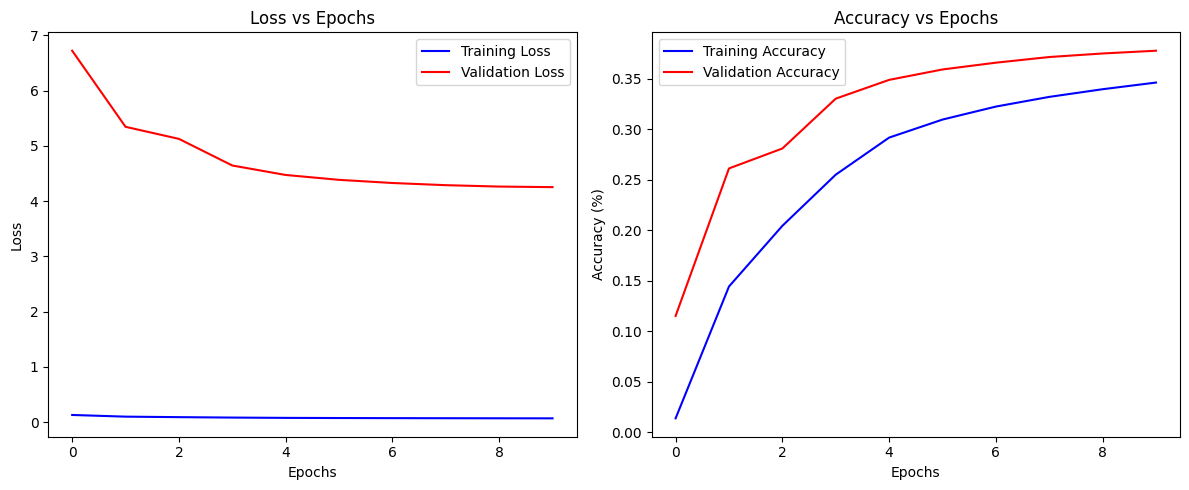

In [ ]:
model_trainer.plot_results(train_results)

#### Testing the model

In [38]:
model_trainer = ModelTrainer(config_file='config.yaml')

In [ ]:
dataset = 'medal'
def test_trained_model(**kwargs):
    model_factory = ModelFactory()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    for model_name in config['model_names']:
        print(f'------- {model_name} --------')

        training_hyperparams = config['training']['hyperparameters']
        model_hyperparams = config['models'][model_name].get('hyperparameters', {})
        model_baseparams = config['models'][model_name].get('base_params', {})
        num_classes = config['datasets'][dataset]['num_classes']
        create_embedding_layer = config['training']['create_embedding_layer']
        embedding_model = kwargs.get('embedding_model', None)
        embedding_dim = 100
        model_params = {
            **(model_hyperparams if model_hyperparams else {}),
            **(model_baseparams if model_baseparams else {}),
            'num_classes': num_classes,
            'embedding_dim': embedding_dim,
            'create_embedding_layer': create_embedding_layer,
            'embedding_model': embedding_model
        }

        print(model_params)
        model: nn.Module = model_factory.get_model(model_name, **model_params).to(device)
        model_path = 'trained_models/models/medal_glove_200ctx_lstm_and_self_attention_model_model.pth'
        state_dict = torch.load(model_path, map_location='cpu')  # or 'cuda' if using GPU
        model.load_state_dict(state_dict)
        
        
        loss_fn = config['datasets'][dataset]['loss_function']
        label_smoothing = config.get('label_smoothing', 0.1)
        class_weights = None

        if 'class_weights' in config['datasets'][dataset]:
            with open(config['datasets'][dataset]['class_weights'], 'r') as f:
                weights = json.load(f)

            # Convert to torch tensor and move to device
            class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

        criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing, weight=class_weights)

        optimizer_name = config['training']['optimizer']
        learning_rate = training_hyperparams['learning_rate']
        weight_decay = config['training']['weight_decay']

        if optimizer_name == 'adam':
            optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    val_results = model_trainer.evaluate(
        valloader, 
        model,
        criterion
        )
    
test_trained_model(embedding_model=glove_embedding_model)